# Bikeshare Exploratory Data Analysis and Visualization

For this notebook I will be exploring this [bikeshare dataset](https://www.kaggle.com/c/bike-sharing-demand) in order to forecast demand. The features include a series of weather-related statistics as well as date and time data between 2011 and 2012 for a Washington, D.C. bikeshare program.

The kaggle competition that uploaded this dataset measured demand predictions according to the Root Mean Squared Log Error (RMSLE), which is the loss metric I will use to grade my own predictions.

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import calendar
import math
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

%matplotlib inline

In [77]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

I processed a few columns, converting them to data objects or categorical variables.

In [78]:
print('There are %d unique values for workingday.' % len(Counter(train['workingday']).values()))
print('There are %d unique values for holiday.'% len(Counter(train['holiday']).values()))
print('There are %d unique values for weather.'% len(Counter(train['weather']).values()))

There are 2 unique values for workingday.
There are 2 unique values for holiday.
There are 4 unique values for weather.


In [79]:
train["hour"] = pd.DatetimeIndex(train['datetime']).hour
train["month"] = pd.DatetimeIndex(train['datetime']).month
train["weekday"] = pd.DatetimeIndex(train['datetime']).weekday

test["hour"] = pd.DatetimeIndex(test['datetime']).hour
test["month"] = pd.DatetimeIndex(test['datetime']).month
test["weekday"] = pd.DatetimeIndex(test['datetime']).weekday

In [80]:
season = {1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" }
weather = {1: "Clear + Few clouds + Partly cloudy + Partly cloudy", 
                    2 : " Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist ", 
                    3 : " Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds", 
                    4 :" Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog " }
train['season'] = [season[i] for i in train['season']]
train['weather'] = [weather[i] for i in train['weather']]
test['season'] = [season[i] for i in test['season']]
test['weather'] = [weather[i] for i in test['weather']]

In [81]:
cat_col = ['workingday', 'season', 'holiday','weather']
for col in cat_col:
    train[col] = train[col].astype(object)
    test[col] = test[col].astype(object)

In [82]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,81,0.0,3,13,16,0,1,5
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,8,32,40,1,1,5
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,5,27,32,2,1,5
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,3,10,13,3,1,5
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,0,1,1,4,1,5


In [83]:
train.dtypes

datetime       object
season         object
holiday        object
workingday     object
weather        object
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
hour            int64
month           int64
weekday         int64
dtype: object

In [84]:
num_col = train.drop('count', axis=1).select_dtypes(exclude=['object', 'category']).columns.values

In [85]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,81,0.0,3,13,16,0,1,5
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,8,32,40,1,1,5
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,5,27,32,2,1,5
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,3,10,13,3,1,5
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,0,1,1,4,1,5


## Visualizations

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


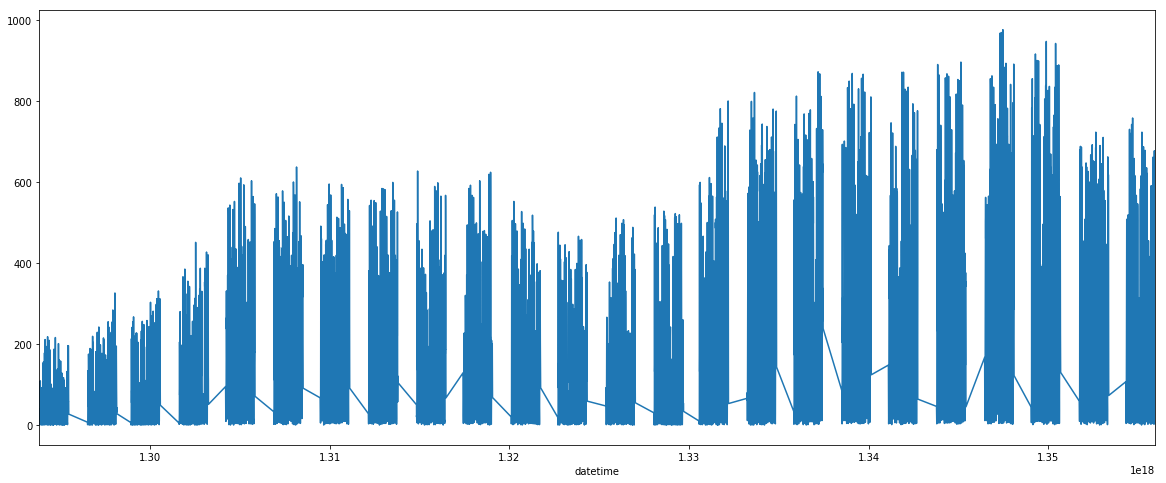

In [86]:
plt.figure(figsize=(20,8))
#plt.plot_date(x=train['datetime'], y=train['count'])
sns.tsplot(data = train['count'], time = pd.to_datetime(train['datetime']))

Text(0.5,1,'Correlation Plot of Numerical Features')

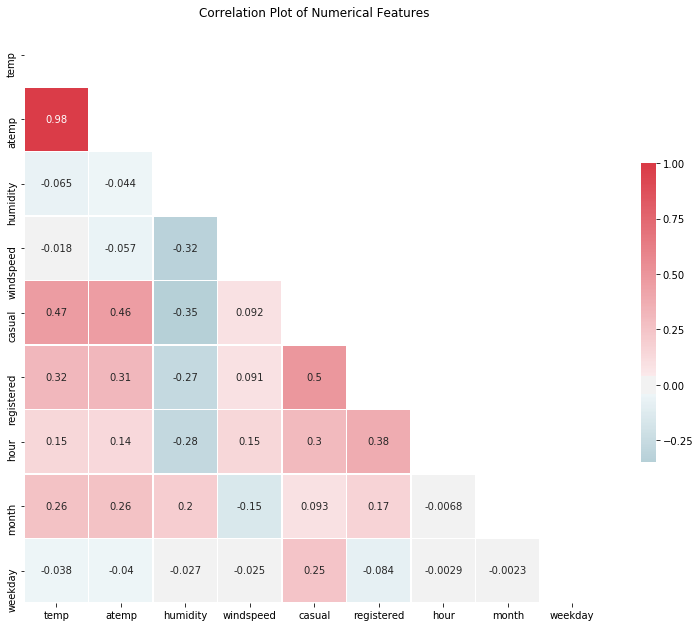

In [87]:
num_train = train[num_col]
cor = num_train.corr()
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(13, 11))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(cor, annot=True, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Plot of Numerical Features")

Quick look at the historical temperatures by month.

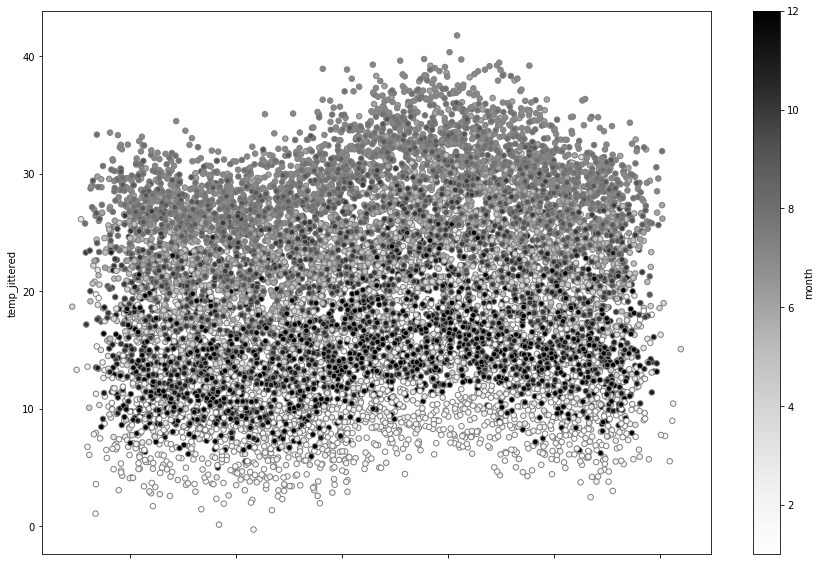

In [88]:
temp = train.copy()
temp["temp_jittered"] = (temp.temp + np.random.randn(len(temp)))
temp["hour_jittered"] = (temp.hour + np.random.randn(len(temp)))
temp.plot(kind='scatter', x='hour_jittered', y='temp_jittered', c='month', s=30, edgecolors='grey', figsize=(15,10))

Text(0.5,1,'Humidity and Count by Season')

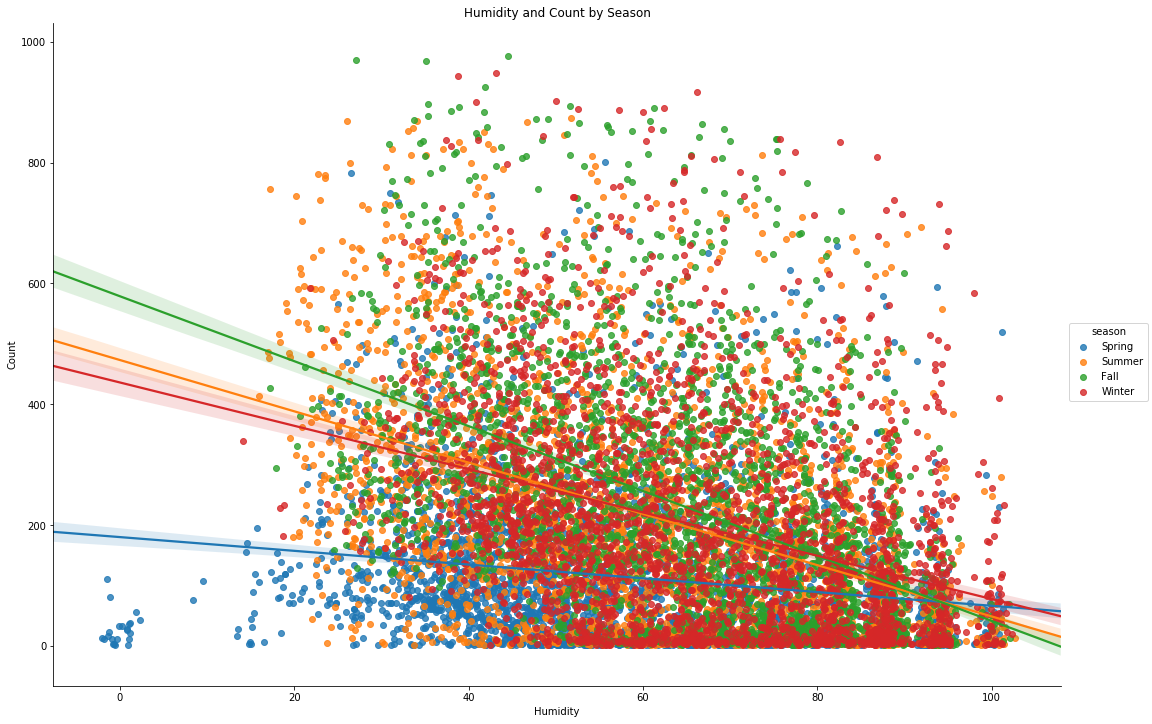

In [127]:
temp = train.copy()
temp["hum_jittered"] = (temp.humidity + np.random.randn(len(temp)))
sns.lmplot(data=temp, y='count', x='hum_jittered', hue='season', size=10, aspect=1.5)
plt.xlabel('Humidity')
plt.ylabel('Count')
plt.title('Humidity and Count by Season')

In [52]:
temp.dtypes

datetime         object
season           object
holiday          object
workingday       object
weather          object
temp            float64
atemp           float64
humidity          int64
windspeed       float64
casual            int64
registered        int64
count             int64
hour              int64
month             int64
weekday           int64
hum_jittered    float64
dtype: object

In [14]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,month,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,81,0.0,3,13,16,0,1,5
1,2011-01-01 01:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,8,32,40,1,1,5
2,2011-01-01 02:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.02,13.635,80,0.0,5,27,32,2,1,5
3,2011-01-01 03:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,3,10,13,3,1,5
4,2011-01-01 04:00:00,Spring,0,0,Clear + Few clouds + Partly cloudy + Partly cl...,9.84,14.395,75,0.0,0,1,1,4,1,5


Text(0,0.5,'Users Count')

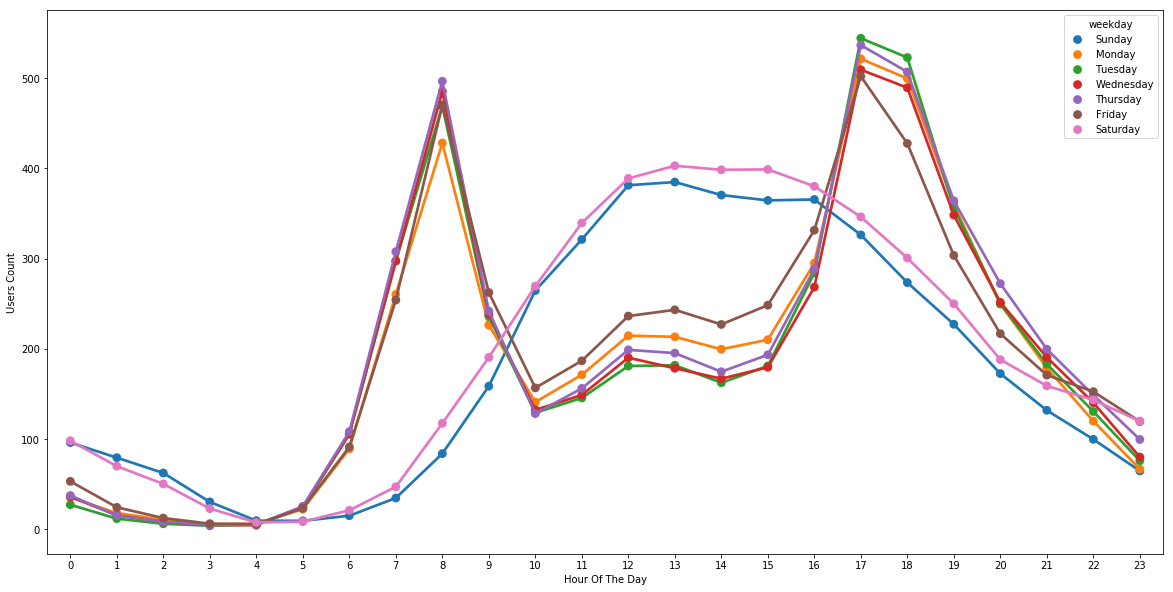

In [23]:
temp = train.copy()
temp["weekday"] = pd.DatetimeIndex(temp['datetime']).weekday_name
plt.figure(figsize=(20,10))

sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

hourAggregated = pd.DataFrame(temp.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True)
plt.xlabel('Hour Of The Day')
plt.ylabel('Users Count')

Text(0,0.5,'Count')

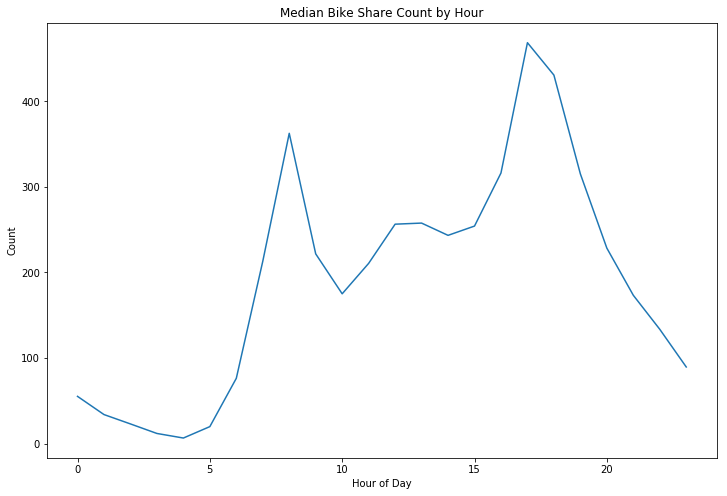

In [16]:
plt.figure(figsize=(12,8))
plt.plot(train.groupby('hour', as_index=False)['count'].mean()['count'])
plt.title('Median Bike Share Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

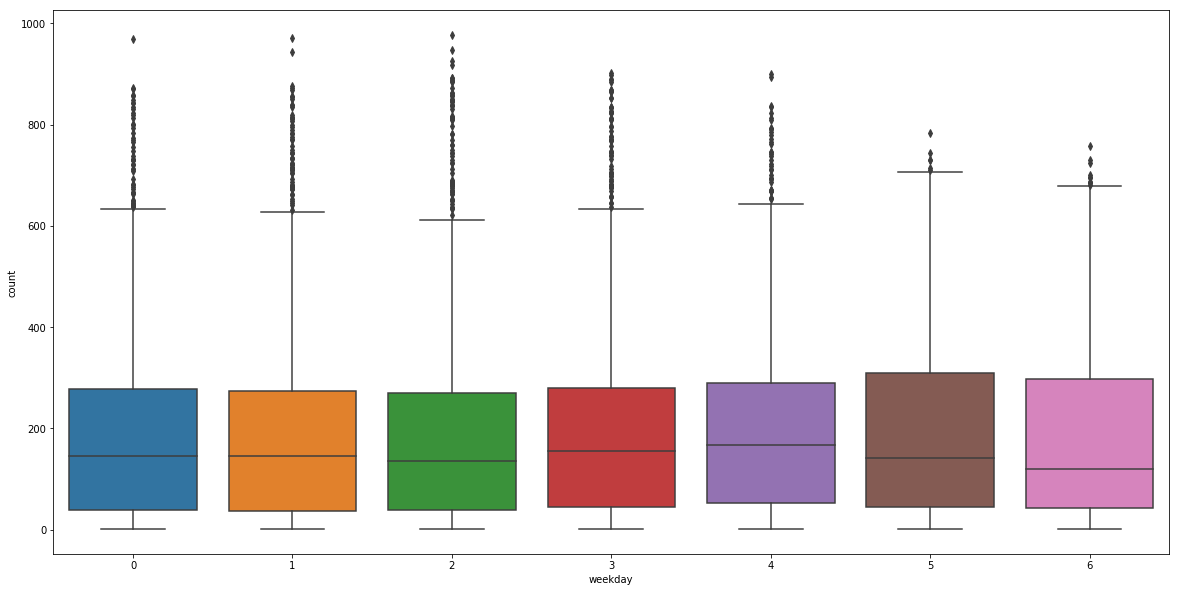

In [17]:
plt.figure(figsize=(20,10))
sns.boxplot(x=train['weekday'], y=train['count'])

Text(0,0.5,'Count')

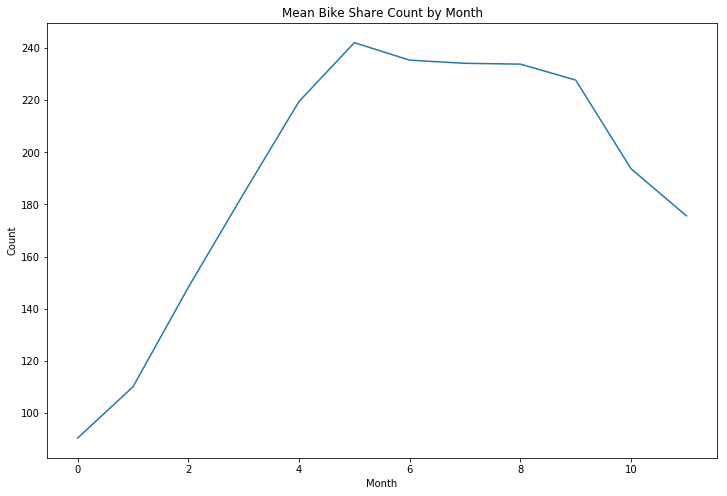

In [18]:
plt.figure(figsize=(12,8))
plt.plot(train.groupby('month', as_index=False)['count'].mean()['count'])
plt.title('Mean Bike Share Count by Month')
plt.xlabel('Month')
plt.ylabel('Count')

## Feature Engineering / PCA

## Prepocessing

In [28]:
train.select_dtypes(include=['object']).columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather'], dtype='object')

In [29]:
train_copy = train.copy()
test_copy = test.copy()
train_copy = pd.get_dummies(train_copy, columns=['holiday', 'workingday', 'season', 'weather', 'weekday', 'month', 'hour'])
test_copy = pd.get_dummies(test_copy, columns=['holiday', 'workingday', 'season', 'weather', 'weekday', 'month', 'hour'])

In [30]:
train_copy = train_copy.drop(['datetime', 'casual', 'registered'], axis=1)
test_copy = test_copy.drop(['datetime'], axis=1)

,temp,atemp,humidity,windspeed,count,holiday_0,holiday_1,workingday_0,workingday_1,season_Fall,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,9.84,14.395,81,0.0000,16,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9.02,13.635,80,0.0000,40,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9.02,13.635,80,0.0000,32,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.84,14.395,75,0.0000,13,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.84,14.395,75,0.0000,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,9.84,12.880,75,6.0032,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6,9.02,13.635,80,0.0000,2,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,8.20,12.880,86,0.0000,3,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9.84,14.395,75,0.0000,8,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,13.12,17.425,76,0.0000,14,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
X_train, X_test, y_train, y_test = train_test_split(train_copy.drop('count', axis=1), 
                                                    train_copy['count'], test_size=0.20, random_state=1987)

## Model

Benchmark model is random_forest (https://www.kaggle.com/benhamner/random-forest-benchmark-2/code).

RMSLE score of 0.59

In [32]:
def rmsle(y_true,y_pred):
   assert len(y_true) == len(y_pred)
   return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

In [34]:
xg_model = xgb.XGBRegressor(n_estimators=1000)
xg_model.fit(X_train,y_train)
output = xg_model.predict(X_test)
print("RMSLE Value For XGBoost: ",rmsle(y_test, output))

RMSLE Value For XGBoost:  0.5798354516169663


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


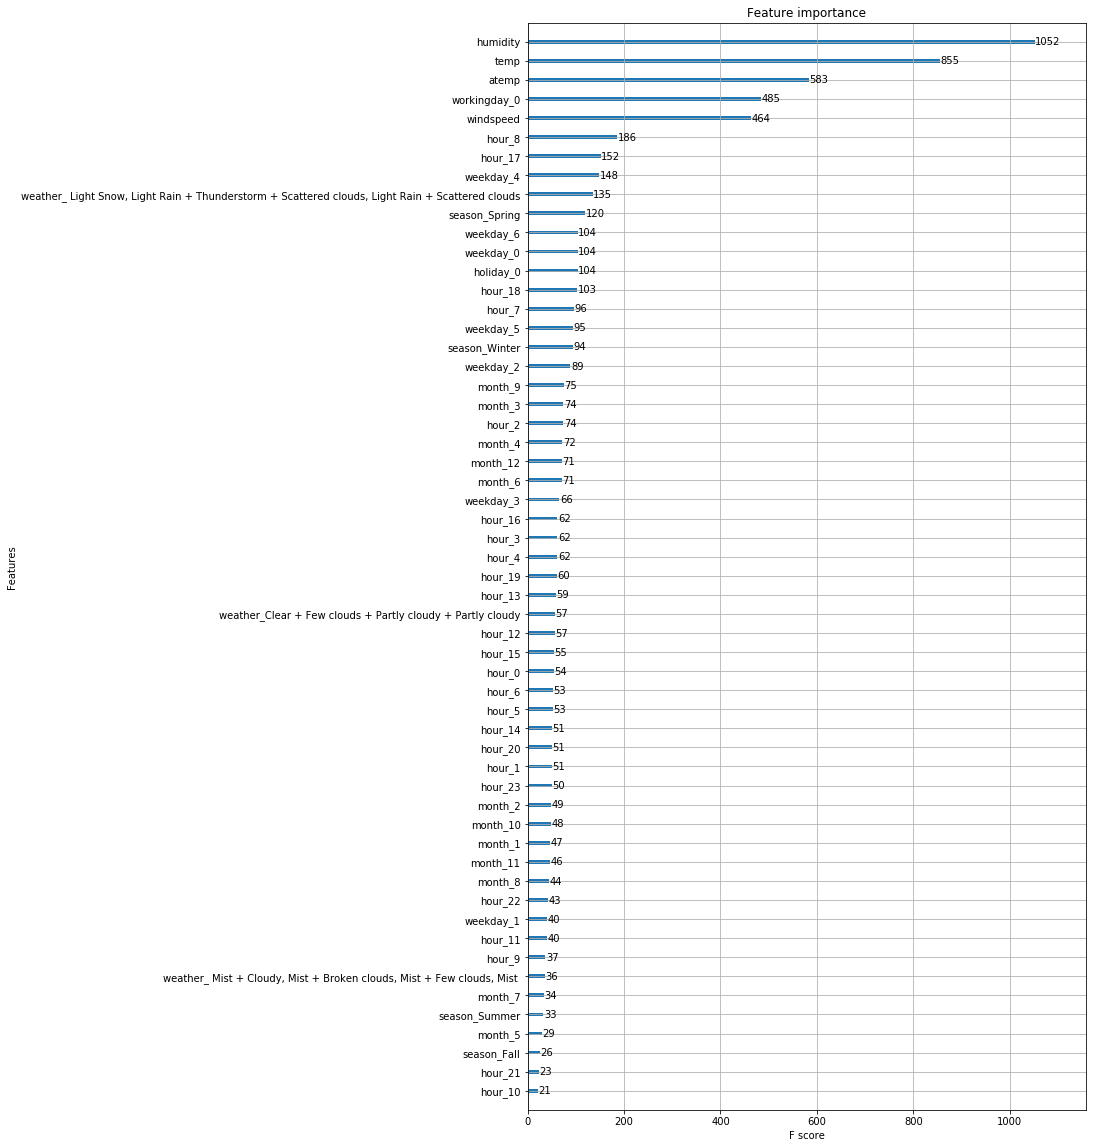

In [35]:
fig, ax = plt.subplots(figsize=(10, 20))
xgb.plot_importance(xg_model, ax=ax)

In [40]:
from sklearn.ensemble import RandomForestRegressor
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [37]:
rf_model = RandomForestRegressor(n_estimators=1000)
rf_model.fit(X_train, y_train)
output = rf_model.predict(X_test)
print("RMSLE Value For Random Forest: ",rmsle(y_test, output))

RMSLE Value For Random Forest:  0.47772021787433
